## **MODULAR REAL TIME MODELING FOR FINANCIAL INSIGHT GENERATION**

In [ ]:
import requests
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
from datetime import datetime
import time

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import cohere
import faiss
from tqdm import tqdm
import random

import praw
import re
from datasets import Dataset
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)
os.chdir("/Users/emmanueladeleye/Documents/DS Projects/Financial Insights Generator/Modular-Real-Time-Financial-News/")
from src.utils import clean_corpus, refine_corpus, news_pull

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/emmanueladeleye/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Pulling all news source

In [4]:
logger.info("Starting the news pull")
full_response, all_text = news_pull('stocks', 'general', include_media=True, media_percent=0.8) # including reddit news
logger.info(f"News pull complete | Total articles fetched: {len(full_response)}")

2026-01-02 12:32:01,699 - INFO - Starting the news pull
2026-01-02 12:32:07,227 - INFO - News pull complete | Total articles fetched: 205


News source distribution

In [13]:
pd.Series(full_response["source"].value_counts())

source
Reddit r/wallstreetbets                            100
NewsAPI                                             97
https://feeds.bloomberg.com/markets/news.rss         4
https://feeds.bloomberg.com/technology/news.rss      2
https://feeds.bloomberg.com/politics/news.rss        1
https://feeds.bloomberg.com/industries/news.rss      1
Name: count, dtype: int64

In [5]:
cleaned_corpus = refine_corpus(all_text)
logger.info(
    "Corpus refined | original=%d | cleaned=%d",
    len(all_text),
    len(cleaned_corpus)
)

2026-01-02 12:40:18,741 - INFO - Corpus refined | original=212189 | cleaned=1009


#### **Search Option 1 - Cohere Embeddings**

In [45]:
load_dotenv()
cohere_api = os.getenv("cohere_api")
co = cohere.Client(cohere_api)
openai_api = os.getenv("openai_api")

In [39]:
def embed_with_backoff(texts, batch_size=90, sleep_time=1):
    embeddings = []
    total_texts = len(texts)
    logger.info("Starting embedding with backoff | total_texts=%d", total_texts)
    for i in tqdm(range(0, total_texts, batch_size)):
        batch_texts = texts[i:i+batch_size]
        success = False
        while not success:
            try:
                response = co.embed(texts=batch_texts, input_type='search_document')
                embeddings.extend(response.embeddings)
                success = True
                logger.info(f"Successfully embedded batch starting from {i} to {i+len(batch_texts)}")
                time.sleep(2) # to respect rate limiting
            except Exception as e:
                logger.warning("Embedding failed for batch starting at index %d: %s. Retrying after %d seconds.", i, str(e), sleep_time)
                time.sleep(sleep_time)
    return embeddings

def search(s_query, number_of_results):
    query_embed = embed_with_backoff([s_query])[0]
    query_vc_np = np.array([query_embed], dtype='float32')
    dimension = query_vc_np.shape[1]
    index = faiss.IndexFlatL2(dimension)
    corpus_embeddings = np.array(embed_with_backoff(cleaned_corpus), dtype='float32')
    index.add(corpus_embeddings)
    distances, similar_items_ids = index.search(query_vc_np, number_of_results)
    results_idx = similar_items_ids[0]
    results_dist = distances[0]

    results = pd.DataFrame({
        "text": np.array(cleaned_corpus)[results_idx],
        "distance": results_dist
    })
    print(f"Search complete | query='{s_query}' | results_returned={len(results)}")
    return results

In [40]:
search('Attack on Putin', 5)

2026-01-02 14:10:44,312 - INFO - Starting embedding with backoff | total_texts=1
  0%|          | 0/1 [00:00<?, ?it/s]2026-01-02 14:10:44,480 - WARNING - Embedding failed for batch starting at index 0: status_code: 429, body: {'id': '9e95b48e-cad7-477f-958a-e9c2494aaf6e', 'message': 'Please wait and try again later'}. Retrying after 1 seconds.
2026-01-02 14:10:45,610 - WARNING - Embedding failed for batch starting at index 0: status_code: 429, body: {'id': 'c03a2901-bacb-4a75-8ce3-8ef36502a691', 'message': 'Please wait and try again later'}. Retrying after 1 seconds.
2026-01-02 14:10:46,755 - WARNING - Embedding failed for batch starting at index 0: status_code: 429, body: {'id': 'c3851caf-e6ff-4620-9b93-05d7f589d16b', 'message': 'Please wait and try again later'}. Retrying after 1 seconds.
2026-01-02 14:10:47,882 - WARNING - Embedding failed for batch starting at index 0: status_code: 429, body: {'id': '6ebd95ff-fe3a-4c2a-9ced-69a1d283b3f5', 'message': 'Please wait and try again later

Search complete | query='Attack on Putin' | results_returned=5


,text,distance
0,"might go on TV, nuke the Venezuela tankers, an...",8007.354004
1,RKLB falling knife YOLO SPACE stocks go brrrr...,9838.594727
2,President Trump got elected vowing to make the...,10186.417969
3,Red Team: Risks Mitigants A light thesis-inva...,10387.067383
4,2026 is the year of space babyyyyt -150k on CV...,10588.357422


#### **Search Option 2 - BM25 + Reranking**

In [41]:
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction import _stop_words
import string

from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.retrievers import BM25Retriever, EnsembleRetriever

In [46]:
# similarity + keyword match
def bm25_tokenizer(text):
    tokenizer_doc = []
    for token in text.lower().split():
        token = token.strip(string.punctuation)

        if len(token)>0 and token not in _stop_words.ENGLISH_STOP_WORDS:
            tokenizer_doc.append(token)

    return tokenizer_doc

def keyword_and_reranking_search(s_query, top_k=5, num_candidates=10, bm25=None):
    print(f'Input Query: {s_query}')

    #### BM25 search lexical search
    bm25_scores = bm25.get_scores(bm25_tokenizer(s_query))
    top_n = np.argpartition(bm25_scores, -num_candidates)[-num_candidates:]
    bm25_hits = [{'corpus_id':idx, 'score':bm25_scores[idx]} for idx in top_n]
    bm25_hits = sorted(bm25_hits, key=lambda x: x['score'], reverse=True)

    print(f'Top-{top_k} Lexical Search (BM25) Hits')

    for hit in bm25_hits[0:top_k]:
        print('\t{:.3f}\t{}'.format(hit['score'], cleaned_corpus[hit['corpus_id']].replace('\n',' ')))

    # Adding reranking
    docs = [cleaned_corpus[hit['corpus_id']] for hit in bm25_hits]

    print(f'\nTop-{top_k} Hits By Rank-API ({len(bm25_hits)} BM25 Hits Re-Ranked)')
    results = co.rerank(query=s_query, documents=docs, top_n=top_k, return_documents=True)

    for hit in results.results:
        print('\t{:.3f}\t{}'.format(hit.relevance_score, hit.document.text.replace('\n','')))

In [47]:
tokenized_corpus = []
for passage in tqdm(cleaned_corpus):
    tokenized_corpus.append(bm25_tokenizer(passage))

bm25 = BM25Okapi(tokenized_corpus)    

100%|██████████| 1009/1009 [00:00<00:00, 17819.62it/s]


In [48]:
keyword_and_reranking_search(s_query='China\'s position on US tarrifs', bm25=bm25)

2026-01-02 14:19:08,229 - INFO - HTTP Request: POST https://api.cohere.com/v1/rerank "HTTP/1.1 200 OK"


Input Query: China's position on US tarrifs
Top-5 Lexical Search (BM25) Hits
	6.099	Thinking about rolling the position, or waiting it out and seeing what happens.
	5.870	no position in any of these names, just fascinated by the biggest media deal since...
	5.103	They have already laid off tens of thousands of employees, they are not in a position to easily fork over cash at a premium for bulk PCslaptops.
	4.790	I think just longing shares is best as the options chain doesnt have much volume but I do have a small 2026 call position open as well.
	4.648	I also have some other short-dated calls I put on just to gain inexpensive leverage to potential MLTX appreciation; the bulk of my position is as a long-term MLTX shareholder.

Top-5 Hits By Rank-API (10 BM25 Hits Re-Ranked)
	0.120	Thinking about rolling the position, or waiting it out and seeing what happens.
	0.059	no position in any of these names, just fascinated by the biggest media deal since...
	0.043	They have already laid off te

#### **Search Option 3 - Implementing Langchain**

In [49]:
from langchain.output_parsers import StructuredOutputParser, ResponseSchema
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI

import openai

In [50]:
response_schemas = [
    ResponseSchema(name="key_insights", description='3-5 bullet points summarizing key insights/outlook on the topic'),
    ResponseSchema(name="key_drivers", description='Main economic/politcal indicators driving the topic'),
    ResponseSchema(name='risks', description='Potential risks associated with the topic'),
    ResponseSchema(name='sentiment', description='Overall social sentiment (positive/negative/neutral with evidence) and degree of sentiment in percentage')    
]
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
format_instructions = output_parser.get_format_instructions()

In [51]:
def analyze_text(s_query, relevant_text):
    
    # initiate llm model
    prompt = ChatPromptTemplate.from_template(
    """
    Analyze the following news corpus regarding {query} and extract:
    {format_instructions}
    
    Corpus:
    {text}
    
    """)
    #client = openai.OpenAI(api_key=openai_key)
    llm = ChatOpenAI(
        model="gpt-3.5-turbo",
        temperature=0.3,
        openai_api_key=openai_api  # Pass key directly or use environment variable
    )

    messages = prompt.format_messages(
        query = s_query,
        text = relevant_text,
        format_instructions=format_instructions
    )

    response = llm(messages)
    return output_parser.parse(response.content)

In [52]:
def create_search_index(full_text):
    # Split text into chunks
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200
    )
    chunks = text_splitter.split_text(full_text)

    # creating searchable index
    embeddings = OpenAIEmbeddings(openai_api_key=openai_api)
    return FAISS.from_texts(chunks, embeddings)    

def analyze_with_semantic_search(s_query, text_list, n_results=10):
    full_texts = " ".join(text_list) if isinstance(text_list, list) else text_list
    # creating vector index on full corpus
    index = create_search_index(full_texts)

    # retreiving relevant chunks
    bm25_retriever = BM25Retriever.from_texts(full_texts)
    faiss_retriever = index.as_retriever()
    ensemble_retriever = EnsembleRetriever(
        retrievers=[bm25_retriever, faiss_retriever], 
        weights=[0.4,0.6]
    )
    
    relevant_text = ensemble_retriever.get_relevant_documents(s_query)
    
    return analyze_text(s_query, relevant_text), relevant_text

#### **Testing**

Including social media

In [57]:
## reruning semantic search on data inclusive of reddit posts
s_query = 'Russia Ukraine war impact on global economy'
full_texts = cleaned_corpus
result, context = analyze_with_semantic_search(s_query, full_texts, n_results=5)

2026-01-02 14:26:05,815 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-02 14:26:07,447 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-02 14:26:10,150 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [58]:
result

{'key_insights': '1. Potential impact of Ukraine war ending on global steel demand and steel companies like Mittal Steel. 2. Potential disruption in oil market due to Iran sanctions and Venezuela production. 3. Expected shift in sentiment for Tesla post earnings report. 4. Influence of inflationary policies and tokenization on the economy. 5. Distribution of humanitarian aid stocks in response to natural disasters.',
 'key_drivers': 'Global steel demand, Iran sanctions, EV sales, inflationary policies, tokenization of stocks, humanitarian aid distribution.',
 'risks': 'Risks associated with geopolitical tensions impacting steel and oil markets, potential economic downturn due to inflation, and market volatility from tokenization.',
 'sentiment': 'Neutral sentiment overall. Positive sentiment towards potential steel demand post Ukraine war, negative sentiment towards potential disruption in oil market, mixed sentiment towards Tesla post earnings, and cautious sentiment towards inflation

Excluding social media

In [61]:
pd.DataFrame(full_response["source"].value_counts())

,count
source,
Reddit r/wallstreetbets,100
NewsAPI,97
https://feeds.bloomberg.com/markets/news.rss,4
https://feeds.bloomberg.com/technology/news.rss,2
https://feeds.bloomberg.com/politics/news.rss,1
https://feeds.bloomberg.com/industries/news.rss,1


In [68]:
full_response.iloc[100]["source"].lower()

'reddit r/wallstreetbets'

In [69]:
len(full_response)

205

In [73]:
full_response_no_reddit = full_response[full_response['source'].str.lower() != 'reddit r/wallstreetbets']
texts_list_no_reddit = full_response_no_reddit['title'] + '\n' + full_response_no_reddit['content']
all_text_no_reddit = "\n".join(texts_list_no_reddit)

In [77]:
## rerunning semantic search on data exclusive of reddit posts
cleaned_texts_no_reddit = refine_corpus(all_text_no_reddit)
result_2, context_2 = analyze_with_semantic_search(s_query, cleaned_texts_no_reddit, n_results=5)

2026-01-02 14:39:10,203 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-02 14:39:12,150 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-02 14:39:15,004 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [78]:
result

{'key_insights': '1. Potential impact of Ukraine war ending on global steel demand and steel companies like Mittal Steel. 2. Potential disruption in oil market due to Iran sanctions and Venezuela production. 3. Expected shift in sentiment for Tesla post earnings report. 4. Influence of inflationary policies and tokenization on the economy. 5. Distribution of humanitarian aid stocks in response to natural disasters.',
 'key_drivers': 'Global steel demand, Iran sanctions, EV sales, inflationary policies, tokenization of stocks, humanitarian aid distribution.',
 'risks': 'Risks associated with geopolitical tensions impacting steel and oil markets, potential economic downturn due to inflation, and market volatility from tokenization.',
 'sentiment': 'Neutral sentiment overall. Positive sentiment towards potential steel demand post Ukraine war, negative sentiment towards potential disruption in oil market, mixed sentiment towards Tesla post earnings, and cautious sentiment towards inflation

In [79]:
result_2

{'key_insights': '1. Global equities are experiencing optimism around economic growth, with European stocks starting the year at all-time highs. 2. Asian technology stocks, particularly chipmakers and AI-related names, are seeing gains. 3. Emerging-market stocks are scaling five-year highs, driven by Asias expanding role in AI. 4. Stocks, gold, and yields are rising in a lively start to 2026. 5. Vodafone Idea shares surged after a settlement deal with Vodafone Group promoters.',
 'key_drivers': 'Global economic growth, optimism in equities markets, technological advancements in AI, settlement deals in telecom sector.',
 'risks': 'Potential risks could include geopolitical tensions impacting markets, volatility in tech sector, and regulatory challenges in emerging markets.',
 'sentiment': 'Neutral. The overall sentiment seems to be positive due to the optimism in equities markets and technological advancements, but there are potential risks that could introduce negative sentiment. The s

#### **Evaluation**

In [80]:
from ragas import evaluate
from ragas.metrics import (faithfulness, answer_relevancy, context_recall, context_precision)

/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_31427/3316452575.py:2: DeprecationWarning: Importing faithfulness from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import faithfulness
  from ragas.metrics import (faithfulness, answer_relevancy, context_recall, context_precision)
/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_31427/3316452575.py:2: DeprecationWarning: Importing answer_relevancy from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import answer_relevancy
  from ragas.metrics import (faithfulness, answer_relevancy, context_recall, context_precision)
/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_31427/3316452575.py:2: DeprecationWarning: Importing context_recall from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'rag

In [81]:
financial_eval_data = {
    "question": [
        "How has the conflict affected the energy sector specifically?",
        "Which specific European indices showed the most resilience?"
    ],
    "sub_query": [
        "impact of Russia Ukraine war on oil and gas stocks 2023",
        "European stock market performance Russia war 2023 FTSE vs DAX"
    ],
    "ground_truth": [
        "Significant volatility in energy prices; windfall profits for global oil majors; shift in European energy dependency.",
        "FTSE 100 often outperformed due to commodity exposure; DAX faced pressure due to industrial energy costs."
    ]
}

In [82]:
results_data = {
    "question": [],
    "answer": [],
    "contexts": [],
    "ground_truth": []
}

full_texts = cleaned_corpus
for query in financial_eval_data['sub_query']:
    result, relevant_text = analyze_with_semantic_search(query, full_texts, n_results=5)
    results_data['question'].append(query)
    results_data['answer'].append(result['key_insights'])
    results_data['contexts'].append([doc.page_content for doc in relevant_text])
    results_data['ground_truth'].append(financial_eval_data['ground_truth'][financial_eval_data['sub_query'].index(query)])

2026-01-02 14:40:20,161 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-02 14:40:22,792 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-02 14:40:24,751 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-02 14:40:25,879 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-02 14:40:27,288 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-02 14:40:29,367 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [83]:
results_data

{'question': ['impact of Russia Ukraine war on oil and gas stocks 2023',
  'European stock market performance Russia war 2023 FTSE vs DAX'],
 'answer': ['1. Potential disruption in oil market due to Venezuela production being taken off the market. 2. Impact of China buying in the open market on oil prices. 3. Expected sentiment shift for TSLA after earnings. 4. Possibility of energy equities outperforming in 2026. 5. Bullish outlook on oil due to supply glut being overstated and demand not as weak as forecasted.',
  'European stocks began the new year at all-time highs, tracking gains across global equities on persisting optimism around economic growth, Chinese multi-asset funds dominated global peers by betting big on tech stocks, Emerging-market stocks scaled five-year highs driven by Asias expanding role in artificial intelligence'],
 'contexts': [['Iran sanctions for years buying all their sanctioned oil on the discount. Its not a huge amount, but taking their Venezuela  production

In [84]:
os.environ["OPENAI_API_KEY"] = openai_api

In [85]:
gpt_turbo = ChatOpenAI(model="gpt-3.5-turbo")
openai_embeddings = OpenAIEmbeddings()

In [87]:
eval_dataset = Dataset.from_dict(results_data)

metrics = [faithfulness, answer_relevancy, context_recall, context_precision]
scores = evaluate(eval_dataset, metrics, llm=gpt_turbo, embeddings=openai_embeddings)

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

2026-01-02 14:41:38,582 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-02 14:41:38,914 - WARNING - LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
2026-01-02 14:41:39,672 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-02 14:41:40,525 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-02 14:41:40,856 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-02 14:41:40,862 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-02 14:41:40,863 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-02 14:41:40,864 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-02 14:41:40,865 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.

In [88]:
df_results = scores.to_pandas()
df_results

,user_input,retrieved_contexts,response,reference,faithfulness,answer_relevancy,context_recall,context_precision
0,impact of Russia Ukraine war on oil and gas st...,[Iran sanctions for years buying all their san...,1. Potential disruption in oil market due to V...,Significant volatility in energy prices; windf...,1.0,0.818483,0.333333,0.0
1,European stock market performance Russia war 2...,[Soars Chinese multi-asset funds trounced thei...,European stocks began the new year at all-time...,FTSE 100 often outperformed due to commodity e...,1.0,0.822037,0.000000,0.0


In [89]:
df_results["user_input"][0]

'impact of Russia Ukraine war on oil and gas stocks 2023'

In [90]:
df_results["response"][0]

'1. Potential disruption in oil market due to Venezuela production being taken off the market. 2. Impact of China buying in the open market on oil prices. 3. Expected sentiment shift for TSLA after earnings. 4. Possibility of energy equities outperforming in 2026. 5. Bullish outlook on oil due to supply glut being overstated and demand not as weak as forecasted.'

In [91]:
df_results["reference"][0]

'Significant volatility in energy prices; windfall profits for global oil majors; shift in European energy dependency.'

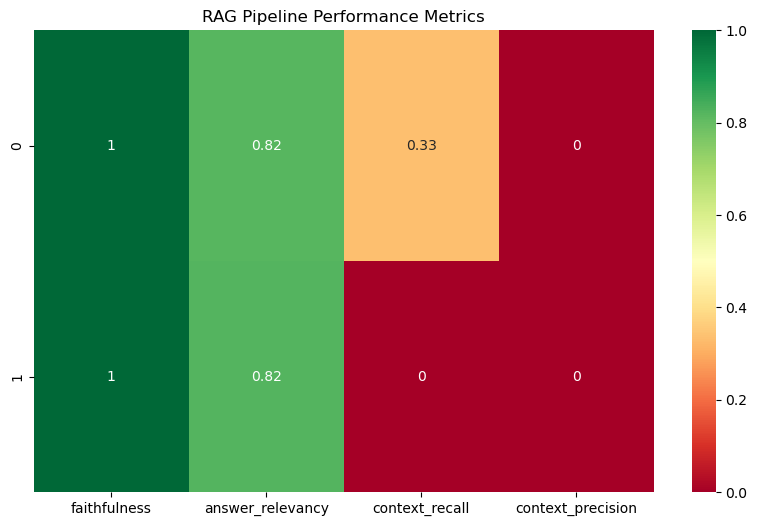

Potential Hallucinations:


In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap of scores
plt.figure(figsize=(10, 6))
sns.heatmap(df_results.iloc[:, 4:], annot=True, cmap="RdYlGn", vmin=0, vmax=1)
plt.title("RAG Pipeline Performance Metrics")
plt.show()

# Print low-faithfulness examples (Potential Hallucinations)
print("Potential Hallucinations:")
low_faith = df_results[df_results["faithfulness"] < 0.7]
for idx, row in low_faith.iterrows():
    print(f"Q: {row['user_input']}")
    print(f"A: {row['response']}")
    print("---")